### Install

### Import libraries

In [1]:
import os
import re
import sys
import time
import logging
import tempfile
from collections import Counter
from typing import List, Tuple

import numpy as np
import pandas as pd

import rdkit
from rdkit import Chem
from rdkit.Chem import MolFromSmiles, MolToSmiles, CanonSmiles

import deepchem as dc
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import cross_validate
from scipy.sparse import csr_matrix, lil_matrix

from utils.utils import configure_logger
from utils.deepchem_feat import smi_canonicalize
from utils.deepchem_feat import (
    AisFeaturizer, SmilesFeaturizer, SmilesPEFeaturizer, SelfiesFeaturizer, DeepSmilesFeaturizer
)

data_dir = './molnet'
if not os.path.exists(data_dir):
    os.mkdir(data_dir)
    
os.environ['DEEPCHEM_DATA_DIR'] = data_dir
spe_vocab = f"{data_dir}/SPE_ChEMBL.txt" # SmilesPE vocabulary 
if not os.path.exists(spe_vocab):
    print('Downloading... SmilesPE vocab file')
    #https://github.com/XinhaoLi74/SmilesPE/blob/master/SPE_ChEMBL.txt 
    ! cd $data_dir  && wget https://raw.githubusercontent.com/XinhaoLi74/SmilesPE/master/SPE_ChEMBL.txt

    

configure_logger(level=logging.INFO)
logger = logging.getLogger(__name__)
os.environ['DEEPCHEM_DATA_DIR']

2023-04-13 14:26:49.533490: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-13 14:26:49.627146: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-04-13 14:26:49.627164: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
Skipped loading some Tensorflow models, missing a dependency. No module named 'google.protobuf'
Skipped loading modules with pytorch-geometric dependency, missing a dependency. No module named 'torch_geometric'
Skipped loading modules with pyto

Downloading... SmilesPE vocab file
--2023-04-13 14:26:50--  https://raw.githubusercontent.com/XinhaoLi74/SmilesPE/master/SPE_ChEMBL.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 27879 (27K) [text/plain]
Saving to: ‘SPE_ChEMBL.txt’

SPE_ChEMBL.txt      100%[===================>]  27.23K  --.-KB/s    in 0.008s  

2023-04-13 14:26:50 (3.40 MB/s) - ‘SPE_ChEMBL.txt’ saved [27879/27879]



'./molnet'

### Tokenizers

In [2]:
tokenizer_feat = {
    'AIS': AisFeaturizer(),
    'SMILES': SmilesFeaturizer(),
    'SmilesPE': SmilesPEFeaturizer(vocab_file=spe_vocab),
    'SELFIES': SelfiesFeaturizer(),
    'DeepSMILES': DeepSmilesFeaturizer(),
}

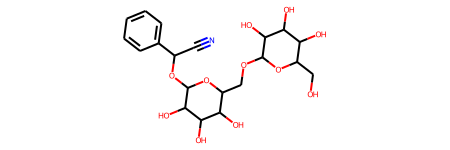

In [3]:
smiles_list = [
    'OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)C(O)C3O ',
    'Cc1occc1C(=O)Nc2ccccc2', 
    'CC(C)=CCCC(C)=CC(=O)',
    'dummysmiles'
]

smiles = smiles_list[0]
mol = Chem.MolFromSmiles(smiles)
mol

In [4]:
aisFeat = tokenizer_feat['AIS']
aisFeat.featurize(smiles_list, )


2023-04-13 14:26:50 - utils.deepchem_feat - INFO - Featurize: AisFeaturizer
2023-04-13 14:26:50 - utils.deepchem_feat - INFO - Featurizing datapoint: 0
[14:26:50] SMILES Parse Error: syntax error while parsing: dummysmiles
[14:26:50] SMILES Parse Error: Failed parsing SMILES 'dummysmiles' for input: 'dummysmiles'
2023-04-13 14:26:50 - utils.deepchem_feat - INFO - # unique tokens: 29


array(['[N;!R;C] # [C;!R;CN] [CH;!R;CCO] ( [O;!R;CC] [CH;R;COO] 1 [O;R;CC] [CH;R;CCO] ( [CH2;!R;CO] [O;!R;CC] [CH;R;COO] 2 [O;R;CC] [CH;R;CCO] ( [CH2;!R;CO] [OH;!R;C] ) [CH;R;CCO] ( [OH;!R;C] ) [CH;R;CCO] ( [OH;!R;C] ) [CH;R;CCO] 2 [OH;!R;C] ) [CH;R;CCO] ( [OH;!R;C] ) [CH;R;CCO] ( [OH;!R;C] ) [CH;R;CCO] 1 [OH;!R;C] ) [c;R;CCC] 1 [cH;R;CC] [cH;R;CC] [cH;R;CC] [cH;R;CC] [cH;R;CC] 1',
       '[CH3;!R;C] [c;R;CCO] 1 [o;R;CC] [cH;R;CO] [cH;R;CC] [c;R;CCC] 1 [C;!R;CNO] ( = [O;!R;C] ) [NH;!R;CC] [c;R;CCN] 1 [cH;R;CC] [cH;R;CC] [cH;R;CC] [cH;R;CC] [cH;R;CC] 1',
       '[CH3;!R;C] [C;!R;CCC] ( [CH3;!R;C] ) = [CH;!R;CC] [CH2;!R;CC] [CH2;!R;CC] [C;!R;CCC] ( [CH3;!R;C] ) = [CH;!R;CC] [CH;!R;CO] = [O;!R;C]'],
      dtype='<U374')

In [5]:
smiFeat = tokenizer_feat['SMILES']
smiFeat.featurize(smiles_list)


2023-04-13 14:26:50 - utils.deepchem_feat - INFO - Featurize: SmilesFeaturizer
2023-04-13 14:26:50 - utils.deepchem_feat - INFO - Featurizing datapoint: 0
[14:26:50] SMILES Parse Error: syntax error while parsing: dummysmiles
[14:26:50] SMILES Parse Error: Failed parsing SMILES 'dummysmiles' for input: 'dummysmiles'
2023-04-13 14:26:50 - utils.deepchem_feat - INFO - # unique tokens: 11


array(['N # C C ( O C 1 O C ( C O C 2 O C ( C O ) C ( O ) C ( O ) C 2 O ) C ( O ) C ( O ) C 1 O ) c 1 c c c c c 1',
       'C c 1 o c c c 1 C ( = O ) N c 1 c c c c c 1',
       'C C ( C ) = C C C C ( C ) = C C = O'], dtype='<U105')

In [6]:
speFeat = tokenizer_feat['SmilesPE']
speFeat.featurize(smiles_list)


2023-04-13 14:26:50 - utils.deepchem_feat - INFO - Featurize: SmilesPEFeaturizer
2023-04-13 14:26:50 - utils.deepchem_feat - INFO - Featurizing datapoint: 0
[14:26:50] SMILES Parse Error: syntax error while parsing: dummysmiles
[14:26:50] SMILES Parse Error: Failed parsing SMILES 'dummysmiles' for input: 'dummysmiles'
2023-04-13 14:26:50 - utils.deepchem_feat - INFO - # unique tokens: 19


array(['N# CC( OC1 OC( CO C2 OC(CO) C(O)C(O) C2 O) C(O)C(O) C1 O) c1ccccc1',
       'Cc1o ccc1 C(=O)Nc1ccccc1', 'CC(C)= CCCC(C) = CC =O'], dtype='<U66')

In [7]:
sfFeat = tokenizer_feat['SELFIES']
sfFeat.featurize(smiles_list)

2023-04-13 14:26:50 - utils.deepchem_feat - INFO - Featurize: SelfiesFeaturizer
2023-04-13 14:26:50 - utils.deepchem_feat - INFO - Featurizing datapoint: 0
[14:26:50] SMILES Parse Error: syntax error while parsing: dummysmiles
[14:26:50] SMILES Parse Error: Failed parsing SMILES 'dummysmiles' for input: 'dummysmiles'
2023-04-13 14:26:50 - utils.deepchem_feat - INFO - # unique tokens: 13


array(['[N] [#C] [C] [Branch2_1] [Ring2] [Branch2_3] [O] [C] [O] [C] [Branch2_1] [Ring1] [Branch1_2] [C] [O] [C] [O] [C] [Branch1_1] [Ring1] [C] [O] [C] [Branch1_1] [C] [O] [C] [Branch1_1] [C] [O] [C] [Ring1] [Branch2_3] [O] [C] [Branch1_1] [C] [O] [C] [Branch1_1] [C] [O] [C] [Ring2] [Ring1] [Branch1_1] [O] [C] [=C] [C] [=C] [C] [=C] [Ring1] [Branch1_2]',
       '[C] [C] [O] [C] [=C] [C] [Expl=Ring1] [Branch1_1] [C] [Branch1_2] [C] [=O] [N] [C] [=C] [C] [=C] [C] [=C] [Ring1] [Branch1_2]',
       '[C] [C] [Branch1_1] [C] [C] [=C] [C] [C] [C] [Branch1_1] [C] [C] [=C] [C] [=O]'],
      dtype='<U347')

In [8]:
deepFeat = tokenizer_feat['DeepSMILES']
deepFeat.featurize(smiles_list)
    

2023-04-13 14:26:50 - utils.deepchem_feat - INFO - Featurize: DeepSmilesFeaturizer
2023-04-13 14:26:50 - utils.deepchem_feat - INFO - Featurizing datapoint: 0
[14:26:50] SMILES Parse Error: syntax error while parsing: dummysmiles
[14:26:50] SMILES Parse Error: Failed parsing SMILES 'dummysmiles' for input: 'dummysmiles'
2023-04-13 14:26:50 - utils.deepchem_feat - INFO - # unique tokens: 10


array(['N # C C O C O C C O C O C C O ) ) C O ) C O ) C 6 O ) ) ) ) ) ) ) ) ) C O ) C O ) C 6 O ) ) ) ) ) ) ) ) c c c c c c 6',
       'C c o c c c 5 C = O ) N c c c c c c 6',
       'C C C ) = C C C C C ) = C C = O'], dtype='<U117')

# Train & Evaluate 

In [9]:
def train_test(name, data_loader, rf_model, scoring):
    
    tokenizer_feat = {
        'AIS': AisFeaturizer(),
        'SMILES': SmilesFeaturizer(),
        'SmilesPE': SmilesPEFeaturizer(vocab_file=spe_vocab),
        'SELFIES': SelfiesFeaturizer(),
        'DeepSMILES': DeepSmilesFeaturizer(),
    }
    tasks, datasets, transformation = data_loader(featurizer=dc.feat.DummyFeaturizer(), splitter=None, seed=0)
    raw_data_df = datasets[0].to_dataframe()
    raw_data_df['canon_smi'] = raw_data_df['X'].apply(smi_canonicalize)
    raw_data_df = raw_data_df[raw_data_df['canon_smi'] != 0]   

    tmp_results = []
    task_name = 'y'
    for tokenizer_name, featurizer in tokenizer_feat.items():
        raw_data_df[tokenizer_name] = raw_data_df['canon_smi'].apply(featurizer._featurize)

        data_updated = raw_data_df[raw_data_df[tokenizer_name] != 0]
        data_updated

        corpus = []
        for datapoint in data_updated[tokenizer_name]:
            corpus.extend(datapoint.split())

        token_count = Counter(corpus)
        vocab = { token:i for i, (token, count) in enumerate(sorted(token_count.items(), key=lambda x: x[1], reverse=True))}
        vocab_size = len(vocab)
        num_data = len(data_updated)
        vocab_size, num_data

        # Initialize a matrix of zeros with shape (num_data, vocab_size)
        binary_matrix = lil_matrix((num_data, vocab_size), dtype=np.int8)

        # Loop over each sentence and set the appropriate indices to 1
        for i, sentence in enumerate(data_updated[tokenizer_name]):
            words = sentence.split()
            word_indices = [vocab[word] for word in words]
            binary_matrix[i, word_indices] = 1

        model = rf_model()
        scores = cross_validate(model, binary_matrix, data_updated[task_name], cv=5, scoring=scoring)

        score_df = pd.DataFrame(scores)
        score_df = score_df.mean().to_frame().T.rename(index={0: tokenizer_name})
        score_df.rename(columns={k: k.replace('test_', '') for k in score_df.columns}, inplace=True)

        df = score_df.drop(['fit_time', 'score_time'], axis=1)
        tmp_results.append(df)
        logger.info(f'{mode} task completed: {tokenizer_name}')

    # regression_results[name] = pd.concat(tmp_results)
    return pd.concat(tmp_results)
    

## Regression tasks

In [10]:
regression_results = {}

mode = 'regression'
scoring=['neg_mean_squared_error', 'neg_mean_absolute_error', 'r2', 'neg_root_mean_squared_error', ]



### Delaney dataset
The Delaney (ESOL) dataset a regression dataset containing structures and water solubility data for 1128 compounds. The dataset is widely used to validate machine learning models on estimating solubility directly from molecular structures (as encoded in SMILES strings).



In [11]:

name='ESolv'
data_loader = dc.molnet.load_delaney

scoring=['neg_mean_squared_error', 'neg_mean_absolute_error', 'r2', 'neg_root_mean_squared_error', ]
rf_model = RandomForestRegressor

tmp_results = train_test(name, data_loader, rf_model=rf_model, scoring=scoring)
regression_results[name] = tmp_results
tmp_results

2023-04-13 14:26:50 - deepchem.molnet.load_function.molnet_loader - INFO - About to featurize delaney dataset.
2023-04-13 14:26:52 - deepchem.data.data_loader - INFO - Loading raw samples now.
2023-04-13 14:26:52 - deepchem.data.data_loader - INFO - shard_size: 8192
2023-04-13 14:26:52 - deepchem.utils.data_utils - INFO - About to start loading CSV from ./molnet/delaney-processed.csv
2023-04-13 14:26:52 - deepchem.utils.data_utils - INFO - Loading shard 1 of size 8192.
2023-04-13 14:26:52 - deepchem.data.data_loader - INFO - About to featurize shard.
2023-04-13 14:26:52 - deepchem.data.data_loader - INFO - TIMING: featurizing shard 0 took 0.004 s
2023-04-13 14:26:52 - deepchem.data.datasets - INFO - TIMING: dataset construction took 0.022 s
2023-04-13 14:26:52 - deepchem.data.datasets - INFO - Loading dataset from disk.
2023-04-13 14:26:52 - deepchem.molnet.load_function.molnet_loader - INFO - About to transform data.
2023-04-13 14:26:52 - deepchem.data.datasets - INFO - Transforming s

,neg_mean_squared_error,neg_mean_absolute_error,r2,neg_root_mean_squared_error
AIS,-0.306959,-0.411831,0.690953,-0.552831
SMILES,-0.392481,-0.470180,0.605717,-0.625918
SmilesPE,-0.475012,-0.521653,0.521785,-0.688740
SELFIES,-0.454229,-0.504488,0.542960,-0.673193
DeepSMILES,-0.401048,-0.468328,0.596809,-0.631869


### FreeSolv - dataset
The FreeSolv dataset is a collection of experimental and calculated hydration free energies for small molecules in water, along with their experiemental values. Here, we are using a modified version of the dataset with the molecule smile string and the corresponding experimental hydration free energies.The FreeSolv dataset is a collection of experimental and calculated hydration free energies for small molecules in water, along with their experiemental values. Here, we are using a modified version of the dataset with the molecule smile string and the corresponding experimental hydration free energies.

In [12]:

name='FreeSolv'
data_loader = dc.molnet.load_freesolv

scoring=['neg_mean_squared_error', 'neg_mean_absolute_error', 'r2', 'neg_root_mean_squared_error', ]
rf_model = RandomForestRegressor

tmp_results = train_test(name, data_loader, rf_model=rf_model, scoring=scoring)
regression_results[name] = tmp_results
tmp_results

2023-04-13 14:27:10 - deepchem.molnet.load_function.molnet_loader - INFO - About to featurize freesolv dataset.
2023-04-13 14:27:11 - deepchem.data.data_loader - INFO - Loading raw samples now.
2023-04-13 14:27:11 - deepchem.data.data_loader - INFO - shard_size: 8192
2023-04-13 14:27:11 - deepchem.utils.data_utils - INFO - About to start loading CSV from ./molnet/freesolv.csv.gz
2023-04-13 14:27:11 - deepchem.utils.data_utils - INFO - Loading shard 1 of size 8192.
2023-04-13 14:27:11 - deepchem.data.data_loader - INFO - About to featurize shard.
2023-04-13 14:27:11 - deepchem.data.data_loader - INFO - TIMING: featurizing shard 0 took 0.001 s
2023-04-13 14:27:11 - deepchem.data.datasets - INFO - TIMING: dataset construction took 0.006 s
2023-04-13 14:27:11 - deepchem.data.datasets - INFO - Loading dataset from disk.
2023-04-13 14:27:11 - deepchem.molnet.load_function.molnet_loader - INFO - About to transform data.
2023-04-13 14:27:11 - deepchem.data.datasets - INFO - Transforming shard 

,neg_mean_squared_error,neg_mean_absolute_error,r2,neg_root_mean_squared_error
AIS,-0.206088,-0.261065,0.795360,-0.448549
SMILES,-0.306050,-0.311984,0.685009,-0.543346
SmilesPE,-0.541730,-0.549054,0.451959,-0.734576
SELFIES,-0.324507,-0.328104,0.668983,-0.563972
DeepSMILES,-0.303247,-0.318328,0.690454,-0.542260


### Lipo - Lipophilicity dataset
Lipophilicity is an important feature of drug molecules that affects both membrane permeability and solubility. The lipophilicity dataset, curated from ChEMBL database, provides experimental results of octanol/water distribution coefficient (logD at pH 7.4) of 4200 compounds.Lipophilicity is an important feature of drug molecules that affects both membrane permeability and solubility. The lipophilicity dataset, curated from ChEMBL database, provides experimental results of octanol/water distribution coefficient (logD at pH 7.4) of 4200 compounds.

In [13]:

name='Lipo'
data_loader = dc.molnet.load_lipo

scoring=['neg_mean_squared_error', 'neg_mean_absolute_error', 'r2', 'neg_root_mean_squared_error', ]
rf_model = RandomForestRegressor

tmp_results = train_test(name, data_loader, rf_model=rf_model, scoring=scoring)
regression_results[name] = tmp_results
tmp_results

2023-04-13 14:27:19 - deepchem.molnet.load_function.molnet_loader - INFO - About to featurize lipo dataset.
2023-04-13 14:27:21 - deepchem.data.data_loader - INFO - Loading raw samples now.
2023-04-13 14:27:21 - deepchem.data.data_loader - INFO - shard_size: 8192
2023-04-13 14:27:21 - deepchem.utils.data_utils - INFO - About to start loading CSV from ./molnet/Lipophilicity.csv
2023-04-13 14:27:21 - deepchem.utils.data_utils - INFO - Loading shard 1 of size 8192.
2023-04-13 14:27:21 - deepchem.data.data_loader - INFO - About to featurize shard.
2023-04-13 14:27:21 - deepchem.data.data_loader - INFO - TIMING: featurizing shard 0 took 0.009 s
2023-04-13 14:27:21 - deepchem.data.datasets - INFO - TIMING: dataset construction took 0.050 s
2023-04-13 14:27:21 - deepchem.data.datasets - INFO - Loading dataset from disk.
2023-04-13 14:27:21 - deepchem.molnet.load_function.molnet_loader - INFO - About to transform data.
2023-04-13 14:27:21 - deepchem.data.datasets - INFO - Transforming shard 0/

,neg_mean_squared_error,neg_mean_absolute_error,r2,neg_root_mean_squared_error
AIS,-0.466299,-0.512909,0.533181,-0.682668
SMILES,-0.852757,-0.716079,0.146537,-0.923086
SmilesPE,-0.641886,-0.602840,0.357088,-0.800825
SELFIES,-0.869994,-0.720366,0.128548,-0.932581
DeepSMILES,-0.798293,-0.695053,0.201498,-0.892953


### Regression results


In [14]:
regression_results_df = pd.concat(regression_results)
regression_results_df.to_csv(f'{data_dir}/regression_results.csv')
regression_results_df

neg_mean_squared_error  neg_mean_absolute_error  \
ESolv    AIS                      -0.306959                -0.411831   
         SMILES                   -0.392481                -0.470180   
         SmilesPE                 -0.475012                -0.521653   
         SELFIES                  -0.454229                -0.504488   
         DeepSMILES               -0.401048                -0.468328   
FreeSolv AIS                      -0.206088                -0.261065   
         SMILES                   -0.306050                -0.311984   
         SmilesPE                 -0.541730                -0.549054   
         SELFIES                  -0.324507                -0.328104   
         DeepSMILES               -0.303247                -0.318328   
Lipo     AIS                      -0.466299                -0.512909   
         SMILES                   -0.852757                -0.716079   
         SmilesPE                 -0.641886                -0.602840   
         SELFIES                  -0.869994                -0.720366   
         DeepSMILES               -0.798293                -0.695053   

                           r2  neg_root_mean_squared_error  
ESolv    AIS         0.690953                    -0.552831  
         SMILES      0.605717                    -0.625918  
         SmilesPE    0.521785                    -0.688740  
         SELFIES     0.542960                    -0.673193  
         DeepSMILES  0.596809                    -0.631869  
FreeSolv AIS         0.795360                    -0.448549  
         SMILES      0.685009                    -0.543346  
         SmilesPE    0.451959                    -0.734576  
         SELFIES     0.668983                    -0.563972  
         DeepSMILES  0.690454                    -0.542260  
Lipo     AIS         0.533181                    -0.682668  
         SMILES      0.146537                    -0.923086  
         SmilesPE    0.357088                    -0.800825  
         SELFIES     0.128548                    -0.932581  
         DeepSMILES  0.201498                    -0.892953

In [15]:
regression_table = {}
for name, result in regression_results.items():
    df = result[['neg_root_mean_squared_error']].T
    # neg_root_mean_squared_error higher is better
    usign = (df * -1).rename(index={'neg_root_mean_squared_error': 'RMSE'}) # changing the sign. Lower is better now
    regression_table[name] = usign.round(3)

regression_table = pd.concat(regression_table)[['SMILES', 'DeepSMILES', 'SELFIES', 'SmilesPE', 'AIS']]
regression_table



,,SMILES,DeepSMILES,SELFIES,SmilesPE,AIS
ESolv,RMSE,0.626,0.632,0.673,0.689,0.553
FreeSolv,RMSE,0.543,0.542,0.564,0.735,0.449
Lipo,RMSE,0.923,0.893,0.933,0.801,0.683


## Classification task:

In [16]:
classification_results = {}

mode = 'classification'
scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc', 'average_precision', 'balanced_accuracy']


### BBBBP  
The blood-brain barrier penetration (BBBP) dataset is designed for the modeling and prediction of barrier permeability. As a membrane separating circulating blood and brain extracellular fluid, the blood-brain barrier blocks most drugs, hormones and neurotransmitters. Thus penetration of the barrier forms a long-standing issue in development of drugs targeting central nervous system.The blood-brain barrier penetration (BBBP) dataset is designed for the modeling and prediction of barrier permeability. As a membrane separating circulating blood and brain extracellular fluid, the blood-brain barrier blocks most drugs, hormones and neurotransmitters. Thus penetration of the barrier forms a long-standing issue in development of drugs targeting central nervous system.

In [17]:

name='BBBP'
data_loader = dc.molnet.load_bbbp

scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc', 'average_precision', 'balanced_accuracy']
rf_model = RandomForestClassifier

tmp_results = train_test(name, data_loader, rf_model=rf_model, scoring=scoring)
classification_results[name] = tmp_results
tmp_results

2023-04-13 14:30:32 - deepchem.molnet.load_function.molnet_loader - INFO - About to featurize bbbp dataset.
2023-04-13 14:30:33 - deepchem.data.data_loader - INFO - Loading raw samples now.
2023-04-13 14:30:33 - deepchem.data.data_loader - INFO - shard_size: 8192
2023-04-13 14:30:33 - deepchem.utils.data_utils - INFO - About to start loading CSV from ./molnet/BBBP.csv
2023-04-13 14:30:33 - deepchem.utils.data_utils - INFO - Loading shard 1 of size 8192.
2023-04-13 14:30:33 - deepchem.data.data_loader - INFO - About to featurize shard.
2023-04-13 14:30:33 - deepchem.data.data_loader - INFO - TIMING: featurizing shard 0 took 0.011 s
2023-04-13 14:30:33 - deepchem.data.datasets - INFO - TIMING: dataset construction took 0.044 s
2023-04-13 14:30:33 - deepchem.data.datasets - INFO - Loading dataset from disk.
2023-04-13 14:30:33 - deepchem.molnet.load_function.molnet_loader - INFO - About to transform data.
2023-04-13 14:30:33 - deepchem.data.datasets - INFO - Transforming shard 0/1
2023-04

,accuracy,precision,recall,f1,roc_auc,average_precision,balanced_accuracy
AIS,0.849960,0.862874,0.957051,0.906925,0.882290,0.953090,0.729260
SMILES,0.801413,0.833958,0.925641,0.877072,0.758761,0.890873,0.661329
SmilesPE,0.841134,0.855214,0.957051,0.902664,0.845639,0.930517,0.710521
SELFIES,0.803847,0.843700,0.914744,0.877350,0.798782,0.913120,0.678775
DeepSMILES,0.822005,0.844182,0.942949,0.890519,0.777277,0.897935,0.685696



### BACE dataset 
The BACE dataset provides quantitative IC50 and qualitative (binary label) binding results for a set of inhibitors of human beta-secretase 1 (BACE-1).

All data are experimental values reported in scientific literature over the past decade, some with detailed crystal structures available. A collection of 1522 compounds is provided, along with the regression labels of IC50.The BACE dataset provides quantitative IC50 and qualitative (binary label) binding results for a set of inhibitors of human beta-secretase 1 (BACE-1).

All data are experimental values reported in scientific literature over the past decade, some with detailed crystal structures available. A collection of 1522 compounds is provided, along with the regression labels of IC50.

* “class” - Binary labels for inhibitor

In [18]:

name='BACE'
data_loader = dc.molnet.load_bace_classification

scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc', 'average_precision', 'balanced_accuracy']
rf_model = RandomForestClassifier

tmp_results = train_test(name, data_loader, rf_model=rf_model, scoring=scoring)
classification_results[name] = tmp_results
tmp_results

2023-04-13 14:30:49 - deepchem.molnet.load_function.molnet_loader - INFO - About to featurize bace_c dataset.
2023-04-13 14:31:01 - deepchem.data.data_loader - INFO - Loading raw samples now.
2023-04-13 14:31:01 - deepchem.data.data_loader - INFO - shard_size: 8192
2023-04-13 14:31:01 - deepchem.utils.data_utils - INFO - About to start loading CSV from ./molnet/bace.csv
2023-04-13 14:31:01 - deepchem.utils.data_utils - INFO - Loading shard 1 of size 8192.
2023-04-13 14:31:01 - deepchem.data.data_loader - INFO - About to featurize shard.
2023-04-13 14:31:01 - deepchem.data.data_loader - INFO - TIMING: featurizing shard 0 took 0.002 s
2023-04-13 14:31:01 - deepchem.data.datasets - INFO - TIMING: dataset construction took 0.081 s
2023-04-13 14:31:01 - deepchem.data.datasets - INFO - Loading dataset from disk.
2023-04-13 14:31:01 - deepchem.molnet.load_function.molnet_loader - INFO - About to transform data.
2023-04-13 14:31:01 - deepchem.data.datasets - INFO - Transforming shard 0/1
2023-

,accuracy,precision,recall,f1,roc_auc,average_precision,balanced_accuracy
AIS,0.764129,0.785110,0.686404,0.716912,0.833242,0.798959,0.758150
SMILES,0.686134,0.656928,0.679064,0.659573,0.738874,0.684812,0.685788
SmilesPE,0.756186,0.769498,0.679168,0.708984,0.832477,0.782343,0.750271
SELFIES,0.695384,0.680576,0.644375,0.650257,0.746586,0.676397,0.691541
DeepSMILES,0.702645,0.681534,0.681931,0.673215,0.775208,0.731362,0.701184


### HIV - dataset
The HIV dataset was introduced by the Drug Therapeutics Program (DTP) AIDS Antiviral Screen, which tested the ability to inhibit HIV replication for over 40,000 compounds. Screening results were evaluated and placed into three categories: confirmed inactive (CI),confirmed active (CA) and confirmed moderately active (CM). We further combine the latter two labels, making it a classification task between inactive (CI) and active (CA and CM).The HIV dataset was introduced by the Drug Therapeutics Program (DTP) AIDS Antiviral Screen, which tested the ability to inhibit HIV replication for over 40,000 compounds. Screening results were evaluated and placed into three categories: confirmed inactive (CI),confirmed active (CA) and confirmed moderately active (CM). We further combine the latter two labels, making it a classification task between inactive (CI) and active (CA and CM).

* “HIV_active”: Binary labels for screening results: 1 (CA/CM) and 0 (CI)

In [19]:

name='HIV'
data_loader = dc.molnet.load_hiv

scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc', 'average_precision', 'balanced_accuracy']
rf_model = RandomForestClassifier

tmp_results = train_test(name, data_loader, rf_model=rf_model, scoring=scoring)
classification_results[name] = tmp_results
tmp_results

2023-04-13 14:31:14 - deepchem.molnet.load_function.molnet_loader - INFO - About to featurize hiv dataset.
2023-04-13 14:31:21 - deepchem.data.data_loader - INFO - Loading raw samples now.
2023-04-13 14:31:21 - deepchem.data.data_loader - INFO - shard_size: 8192
2023-04-13 14:31:21 - deepchem.utils.data_utils - INFO - About to start loading CSV from ./molnet/HIV.csv
2023-04-13 14:31:21 - deepchem.utils.data_utils - INFO - Loading shard 1 of size 8192.
2023-04-13 14:31:21 - deepchem.data.data_loader - INFO - About to featurize shard.
2023-04-13 14:31:21 - deepchem.data.data_loader - INFO - TIMING: featurizing shard 0 took 0.007 s
2023-04-13 14:31:21 - deepchem.utils.data_utils - INFO - Loading shard 2 of size 8192.
2023-04-13 14:31:21 - deepchem.data.data_loader - INFO - About to featurize shard.
2023-04-13 14:31:21 - deepchem.data.data_loader - INFO - TIMING: featurizing shard 1 took 0.010 s
2023-04-13 14:31:21 - deepchem.utils.data_utils - INFO - Loading shard 3 of size 8192.
2023-04-

,accuracy,precision,recall,f1,roc_auc,average_precision,balanced_accuracy
AIS,0.964695,0.437205,0.155366,0.219827,0.720898,0.233380,0.574747
SMILES,0.962920,0.345307,0.106786,0.160891,0.651724,0.141074,0.550419
SmilesPE,0.964986,0.592958,0.131079,0.196739,0.737001,0.239387,0.563196
SELFIES,0.963139,0.379046,0.121338,0.180374,0.653020,0.149800,0.557544
DeepSMILES,0.962701,0.331490,0.112341,0.167223,0.651476,0.148219,0.552983


### Classification results

In [20]:
classification_results_df = pd.concat(classification_results)
classification_results_df.to_csv(f'{data_dir}/classification_results.csv')
classification_results_df

accuracy  precision    recall        f1   roc_auc  \
BBBP AIS         0.849960   0.862874  0.957051  0.906925  0.882290   
     SMILES      0.801413   0.833958  0.925641  0.877072  0.758761   
     SmilesPE    0.841134   0.855214  0.957051  0.902664  0.845639   
     SELFIES     0.803847   0.843700  0.914744  0.877350  0.798782   
     DeepSMILES  0.822005   0.844182  0.942949  0.890519  0.777277   
BACE AIS         0.764129   0.785110  0.686404  0.716912  0.833242   
     SMILES      0.686134   0.656928  0.679064  0.659573  0.738874   
     SmilesPE    0.756186   0.769498  0.679168  0.708984  0.832477   
     SELFIES     0.695384   0.680576  0.644375  0.650257  0.746586   
     DeepSMILES  0.702645   0.681534  0.681931  0.673215  0.775208   
HIV  AIS         0.964695   0.437205  0.155366  0.219827  0.720898   
     SMILES      0.962920   0.345307  0.106786  0.160891  0.651724   
     SmilesPE    0.964986   0.592958  0.131079  0.196739  0.737001   
     SELFIES     0.963139   0.379046  0.121338  0.180374  0.653020   
     DeepSMILES  0.962701   0.331490  0.112341  0.167223  0.651476   

                 average_precision  balanced_accuracy  
BBBP AIS                  0.953090           0.729260  
     SMILES               0.890873           0.661329  
     SmilesPE             0.930517           0.710521  
     SELFIES              0.913120           0.678775  
     DeepSMILES           0.897935           0.685696  
BACE AIS                  0.798959           0.758150  
     SMILES               0.684812           0.685788  
     SmilesPE             0.782343           0.750271  
     SELFIES              0.676397           0.691541  
     DeepSMILES           0.731362           0.701184  
HIV  AIS                  0.233380           0.574747  
     SMILES               0.141074           0.550419  
     SmilesPE             0.239387           0.563196  
     SELFIES              0.149800           0.557544  
     DeepSMILES           0.148219           0.552983

In [21]:
classification_table = {}
for name, result in classification_results.items():
    df = result[['roc_auc']].T 
    
    df.rename(index={'roc_auc': 'ROC-AUC'}, inplace=True)
    classification_table[name] = df.round(3) 
    
classification_table = pd.concat(classification_table)[['SMILES', 'DeepSMILES', 'SELFIES', 'SmilesPE', 'AIS']]
classification_table

,,SMILES,DeepSMILES,SELFIES,SmilesPE,AIS
BBBP,ROC-AUC,0.759,0.777,0.799,0.846,0.882
BACE,ROC-AUC,0.739,0.775,0.747,0.832,0.833
HIV,ROC-AUC,0.652,0.651,0.653,0.737,0.721


# Download the raw datasets